**AUTHOR**: EMMANUEL MASINDI<br>
**DATE**: 02 NOVEMBER 2022<br>
**TITLE**: *NLP PROJECT TO CREATE DEEP LEARNING ALGORITHM TO PREDICT RESTURANT REVIEWS*<br>

In this project, we use an Artificial Neural Network to predict the Sentiment of resturant reviews. Using Neural Networks allows us to increase the number of classes the model can predict. In future excercises, we will to attempt to predict the Sentiment by utilizing a scale between 1 and 5. 

**IMPORT LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**IMPORT DATASET**

In [2]:
# import dataset as a dataframe. Specify delimeter used to store data and specify quoting to eliminate confusion with quotation marks.
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

In [3]:
dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
# dataset contains no null values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


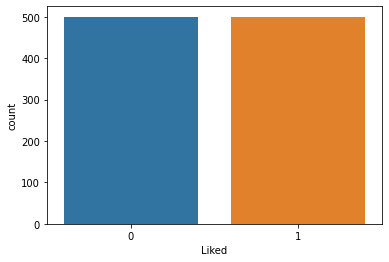

In [5]:
sns.countplot(x = 'Liked', data = dataset)
plt.savefig('Class Count.jpg', bbox_inches = 'tight')
# equal representation of the classes

Let's investigate the correlation between the number of characters and the Review sentiment.

In [6]:
# make a new column 'Review Length' which will be equivolent to number of characters in the Review
dataset['Review Length'] = dataset['Review'].apply(len)
dataset.head()

,Review,Liked,Review Length
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59


Text(10.050000000000004, 0.5, 'Frequency')

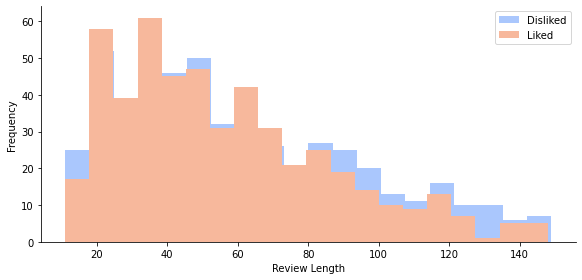

In [7]:
# using a facet grid to map the two distributions we obtain the following
g = sns.FacetGrid(dataset, hue='Liked', palette='coolwarm', height=4, aspect=2)
g = g.map(plt.hist, 'Review Length', bins=20)
plt.legend(['Disliked', 'Liked'], loc = 'upper right')
plt.ylabel('Frequency')
# no obvious difference in distribution between the two classes

The does not appear to be a correlation between text length and customer sentiment. Both classes also have review lengths that span the same ranges.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f13365b34d0>,
      dtype=object)

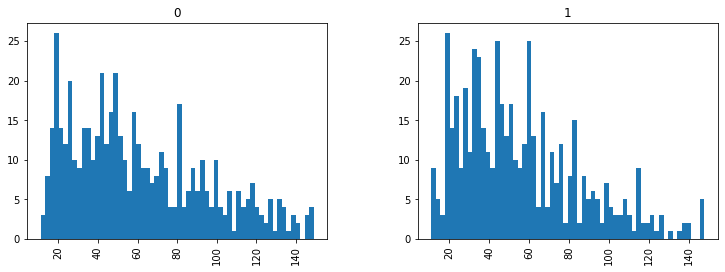

In [8]:
dataset.hist(column = 'Review Length', by = 'Liked', bins = 60, figsize = (12,4))

**EDIT TEXT**

We will next edit the texts to ready them for the bag of words tranformer. The nltk and string library will provide the list of punctuation marks and stopwords (commonly used words which are theorized to not affect model performance) to edit the reviews. 

In [13]:
# import string and nltk then download stopwords
import string
from nltk.corpus import stopwords
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> D

Download which package (l=list; x=cancel)?
  Identifier> stopwords


      Unzipping corpora/stopwords.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [15]:
# some stopwords might be necessary to include as they are used often with negative reviews
# we can create a new list of stopwords that will not be editted out of the reviews

stopwords_to_include = ['not','off','out','down','below','against','but',"wouldn't","wouldn","won't","weren't",
                       "weren","wasn't","shouldn't",'shouldn',"isn't","haven't","hasn't","doesn't","didn't","couldn't","aren't"]
stopwords_to_exclude = [word for word in stopwords.words('english') if word not in stopwords_to_include]

In [16]:
# create function to edit reviews in dataframe
def text_process(review):
    """
    The below function will:
    1. remove punctuation
    2. remove stopwords
    3. return list of clean text words
    """

    global stopwords_to_exclude
    
    nopunc = [char for char in review if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    review_edit = [word for word in nopunc.split() if word.lower() not in stopwords_to_exclude]
    
    return [word.lower() for word in review_edit]

**TRAIN TEST SPLIT**

In [17]:
# split the data between the train and test set and use a test size equal to 30%
from sklearn.model_selection import train_test_split

In [18]:
X = dataset.iloc[:,0:1] 
y = dataset.iloc[:,1:2]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**TRANSFORM REVIEWS TO TFIDF**

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [21]:
# bag of words transformer for both train and test set
bow_transformer = CountVectorizer(analyzer = text_process)
bow_transformer.fit(X_train['Review'])
X_train_bow = bow_transformer.transform(X_train['Review'])
X_test_bow = bow_transformer.transform(X_test['Review'])

In [22]:
# tfidf transformer
# convert output tfidf matrix into an array to ensure compatibility with tensorflow
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_bow)
X_train_tfidf = tfidf_transformer.transform(X_train_bow)
X_test_tfidf = tfidf_transformer.transform(X_test_bow)
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

**BUILDING ARTIFICIAL NEURAL NETWORK**

In [23]:
# import neural netwrok libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [24]:
# minmaxscaler will convert all values to lie between 0 and 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train_tfidf = sc.fit_transform(X_train_tfidf)
X_test_tfidf = sc.transform(X_test_tfidf)

In [25]:
model = Sequential()
model.add(Dense(units=1596, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1000, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1000, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

In [26]:
model.fit(X_train_tfidf, y_train['Liked'], validation_data=(X_test_tfidf, y_test['Liked']), epochs = 25)

Epoch 1/25
22/22 [==============================] - 3s 87ms/step - loss: 0.2360 - accuracy: 0.6000 - val_loss: 0.1848 - val_accuracy: 0.7300
Epoch 2/25
22/22 [==============================] - 2s 73ms/step - loss: 0.0337 - accuracy: 0.9700 - val_loss: 0.1676 - val_accuracy: 0.7933
Epoch 3/25
22/22 [==============================] - 2s 74ms/step - loss: 0.0021 - accuracy: 0.9986 - val_loss: 0.2019 - val_accuracy: 0.7567
Epoch 4/25
22/22 [==============================] - 2s 108ms/step - loss: 1.1999e-04 - accuracy: 1.0000 - val_loss: 0.1898 - val_accuracy: 0.7800
Epoch 5/25
22/22 [==============================] - 2s 73ms/step - loss: 7.0678e-06 - accuracy: 1.0000 - val_loss: 0.1881 - val_accuracy: 0.7833
Epoch 6/25
22/22 [==============================] - 2s 72ms/step - loss: 3.8293e-06 - accuracy: 1.0000 - val_loss: 0.1881 - val_accuracy: 0.7833
Epoch 7/25
22/22 [==============================] - 2s 73ms/step - loss: 1.4924e-05 - accuracy: 1.0000 - val_loss: 0.1896 - val_accuracy: 0.7

**ASSESS MODEL PERFORMANCE**

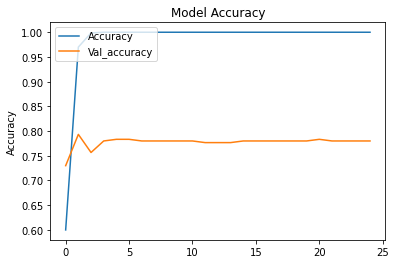

In [27]:
# plot the model performance visualizations and assess probable overfitting
model_performance = pd.DataFrame(model.history.history)
plt.plot(model_performance['accuracy'])
plt.plot(model_performance['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.legend(['Accuracy','Val_accuracy'], loc = 'upper left')

The model ends up with an accuracy of **78%**. It took less than 5 epochs for the model to converge to this accuracy. Not a high degree of overfitting is observed as this accuracy is maintained throughout the entire training phase of the model. <br>
<br>
The high training accuracy (100%) will need to be investigated as this is not entirely reflected on the validation accuracy. The overall size of this dataset might have a part to play in this, due to there being potentially more words in testing set unencountered and thus not included in the bag of words matrix. A larger dataset will most certainly try to address this problem.<br>
<br>
Methods to improve accuracy can include:<br>


*   Updating stopwords and ensuring that we are not editting our valuable information
*   Updating Neural Network by tweaking number of layers and number of neurons

*   Using k-fold validation to see the highest possible accuracy achievable using this dataset
*   Performing more feature engineering to create new columns for the dataset.









